# Explore runtimes for matrix DWPC computation

In [1]:
import numpy
import pathlib
import pandas

import regex
import plotnine as pln

/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
path = pathlib.Path('data/rephetio-DWPCs-hetmech-runtime.tsv')
runtime_df = pandas.read_table(path)
runtime_df.dropna(subset=['dwpc_hetmech_runtime'], inplace=True)
runtime_df.length = pandas.Categorical(runtime_df.length, ordered=True)
runtime_df.head(2)

,abbreviation,category,length,dwpc_hetmech_runtime
0,CbGaD,no_repeats,2,0.81963
1,CbGdD,no_repeats,2,0.79029


## All metapaths

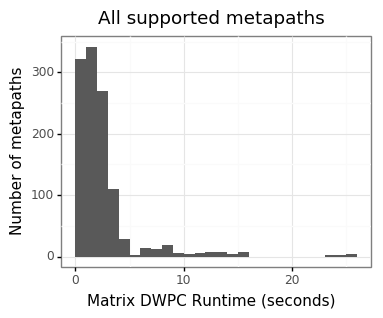

<ggplot: (-9223363284616729852)>

In [3]:
pln.options.figure_size = 4, 3
(
    pln.ggplot(runtime_df, pln.aes(x = 'dwpc_hetmech_runtime')) +
    pln.geom_histogram(breaks=numpy.arange(1 + runtime_df.dwpc_hetmech_runtime.max())) +
    pln.xlab('Matrix DWPC Runtime (seconds)') +
    pln.ylab('Number of metapaths') +
    pln.ggtitle('All supported metapaths') +
    pln.theme_bw()
)

## By number of Genes in metapath

This shows that the longest nine metapaths were all of the G_X_G form

In [4]:
# Dangerous method to count number of Gene metanodes in a metapath
runtime_df['n_genes'] = runtime_df.abbreviation.map(lambda x: x.count('G'))
runtime_df.head(2)

,abbreviation,category,length,dwpc_hetmech_runtime,n_genes
0,CbGaD,no_repeats,2,0.81963,1
1,CbGdD,no_repeats,2,0.79029,1


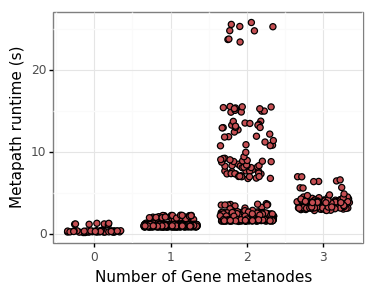

<ggplot: (-9223363284620130886)>

In [5]:
(pln.ggplot(runtime_df, pln.aes(x='n_genes', y='dwpc_hetmech_runtime'))
    + pln.geom_jitter(width=0.35, size=2, fill='#C44E52')
    + pln.xlab('Number of Gene metanodes')
    + pln.ylab('Metapath runtime (s)')
    + pln.theme_bw()
)

## G_X_G metapaths

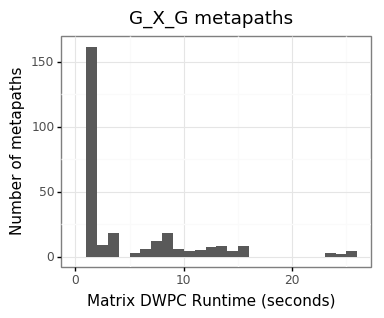

<ggplot: (-9223363284620176468)>

In [6]:
pattern = regex.compile(r'[G][a-z<>{1,2}][A-Z{1,2}][a-z<>{1,2}][G]')
G_G_runtime_df = runtime_df[runtime_df.abbreviation.map(pattern.search).astype(bool)].copy()

(
    pln.ggplot(G_G_runtime_df, pln.aes(x = 'dwpc_hetmech_runtime')) +
    pln.geom_histogram(breaks=numpy.arange(1 + runtime_df.dwpc_hetmech_runtime.max())) +
    pln.xlab('Matrix DWPC Runtime (seconds)') +
    pln.ylab('Number of metapaths') +
    pln.ggtitle('G_X_G metapaths') +
    pln.theme_bw()
)

### Split G_X_G into G_X_G and G_A_G

In [7]:
pattern = regex.compile(r'[G][a-z<>{1,2}][A][a-z<>{1,2}][G]')
G_G_runtime_df['gene_pattern'] = G_G_runtime_df.abbreviation.map(lambda x: 'G_A_G' if pattern.search(x) else 'G_X_G')
G_G_runtime_df.gene_pattern[G_G_runtime_df.abbreviation.str.contains('GeAeG')] = 'GeAeG'
G_G_runtime_df.head(2)

/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,abbreviation,category,length,dwpc_hetmech_runtime,n_genes,gene_pattern
158,CbGaDaGaD,BABA,4,1.7472,2,G_X_G
159,CbGaDaGdD,BABA,4,1.6473,2,G_X_G


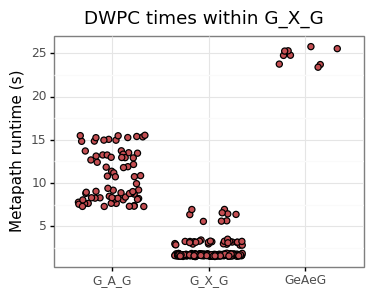

<ggplot: (-9223363284620201973)>

In [8]:
(pln.ggplot(G_G_runtime_df, pln.aes(x='gene_pattern', y='dwpc_hetmech_runtime'))
    + pln.geom_jitter(width=0.35, size=2, fill='#C44E52')
    + pln.xlab('')
    + pln.ylab('Metapath runtime (s)')
    + pln.ggtitle('DWPC times within G_X_G')
    + pln.theme_bw()
)

## By number of metaedges in the metapath

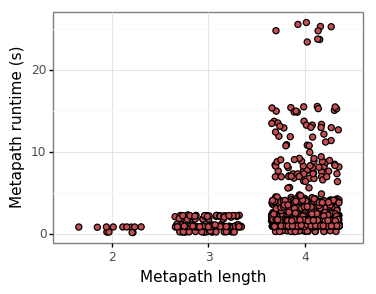

<ggplot: (-9223363284595418017)>

In [9]:
(pln.ggplot(runtime_df, pln.aes(x='length', y='dwpc_hetmech_runtime'))
    + pln.geom_jitter(width=0.35, size=2, fill='#C44E52')
    + pln.xlab('Metapath length')
    + pln.ylab('Metapath runtime (s)')
    + pln.theme_bw()
)

## By category

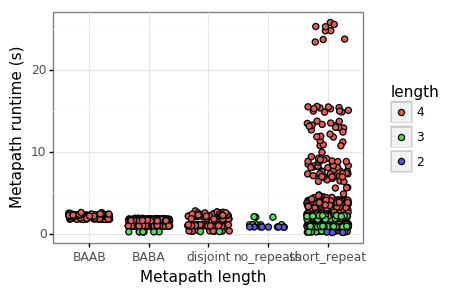

<ggplot: (8752234577230)>

In [10]:
runtime_df.length.cat.reorder_categories([4, 3, 2], inplace=True)
(pln.ggplot(runtime_df, pln.aes(x='category', y='dwpc_hetmech_runtime', fill='length'))
    + pln.geom_jitter(width=0.35, size=2)
    + pln.xlab('Metapath length')
    + pln.ylab('Metapath runtime (s)')
    + pln.theme_bw()
)